In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Jan 20 03:07:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_resblock_encoder import Encoder
from model.prior.randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.dalle_resblock_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 128
hp.hidden_dims = [256, 512]
hp.z_dim = 512
hp.n_prior_embeddings = 512
hp.init_log_sigma = -8
hp.const_sigma = True
hp.quantize = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 17.3046875
encoder.encoder 16.302734375
encoder.out_conv 1.001953125
prior 1.0
latent 3.814697265625e-06
quantizer 0.0
decoder 12.286144256591797
decoder.in_conv 1.001953125
decoder.decoder 11.284191131591797
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 2195, model_list, optimizer_list)

total 441220
-rw-rw-r-- 1 scpark scpark  3934301  1월 20 03:04 events.out.tfevents.1705686374.GPUSVR11
-rw-rw-r-- 1 scpark scpark 86897856  1월 20 03:03 save_40000
-rw-rw-r-- 1 scpark scpark 86897856  1월 20 02:59 save_30000
-rw-rw-r-- 1 scpark scpark 86897856  1월 20 02:55 save_20000
-rw-rw-r-- 1 scpark scpark 86897856  1월 20 02:50 save_10000
-rw-rw-r-- 1 scpark scpark 86892436  1월 20 02:46 save_0
-rw-rw-r-- 1 scpark scpark  1195069  1월 20 02:46 events.out.tfevents.1705686048.GPUSVR11
-rw-rw-r-- 1 scpark scpark  1745175  1월 20 02:41 events.out.tfevents.1705685487.GPUSVR11
-rw-rw-r-- 1 scpark scpark   456093  1월 20 02:31 events.out.tfevents.1705685106.GPUSVR11
-rw-rw-r-- 1 scpark scpark     1581  1월 20 02:24 events.out.tfevents.1705685092.GPUSVR11
-rw-rw-r-- 1 scpark scpark  1336905  1월 20 02:24 events.out.tfevents.1705683989.GPUSVR11
-rw-rw-r-- 1 scpark scpark      359  1월 20 02:06 events.out.tfevents.1705683976.GPUSVR11
-rw-rw-r-- 1 scpark scpark  1386581  1월 20 02:06 events.out.tfevents

### Dataset

In [7]:
from torch.utils.data import DataLoader, Dataset
from data.imagenet_dataset import ImagenetDataset

train_data_dir = '/data/imagenet/val'
train_dataset = ImagenetDataset(root_dir=train_data_dir, img_size=hp.img_size)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

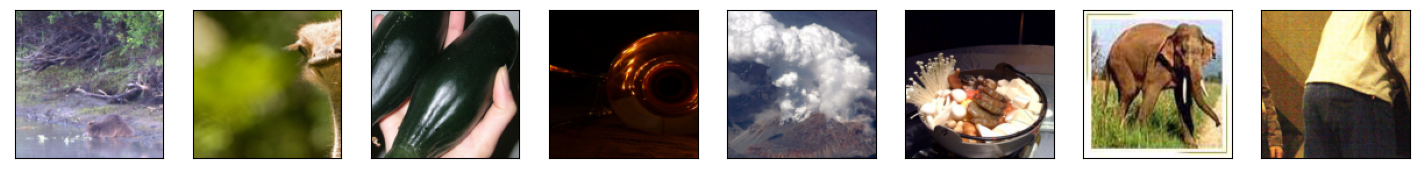

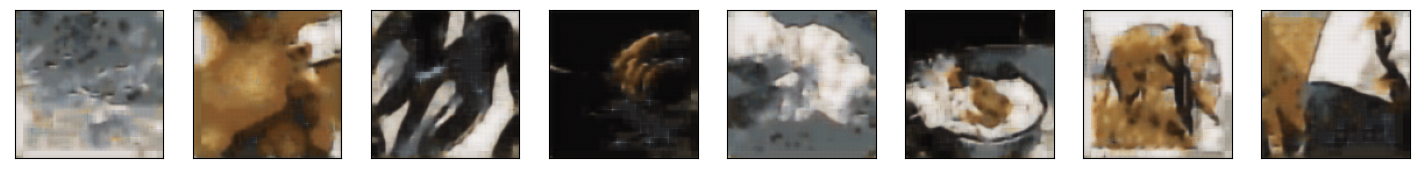

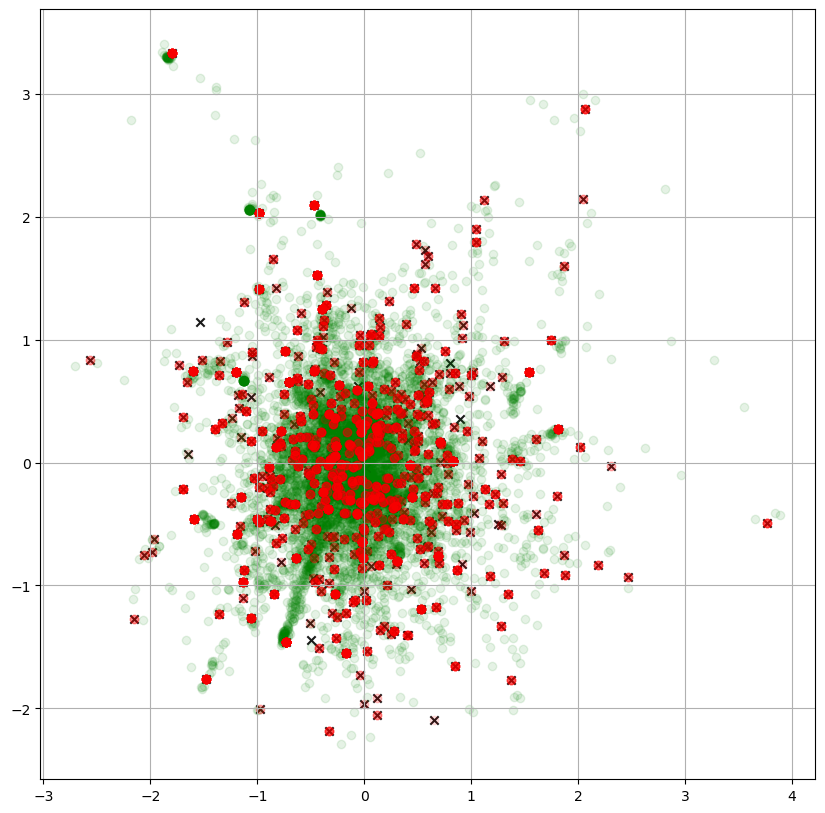

78001
lse_loss 6706030.0
commit_loss 0.02187206968665123
recon_loss 0.014216925017535686
78002
lse_loss 9907801.0
commit_loss 0.021919138729572296
recon_loss 0.012435311451554298
78003
lse_loss 4897510.0
commit_loss 0.022666756063699722
recon_loss 0.01412915624678135
78004
lse_loss 7021192.0
commit_loss 0.02411196008324623
recon_loss 0.0220921840518713
78005
lse_loss 9796713.0
commit_loss 0.02529539167881012
recon_loss 0.011749019846320152
78006
lse_loss 6017822.0
commit_loss 0.024495180696249008
recon_loss 0.025092415511608124
78007
lse_loss 5975731.5
commit_loss 0.023269299417734146
recon_loss 0.015595036558806896
78008
lse_loss 5821235.5
commit_loss 0.021291589364409447
recon_loss 0.01435270719230175
78009
lse_loss 5753661.0
commit_loss 0.022231273353099823
recon_loss 0.013332049362361431
78010
lse_loss 9702777.0
commit_loss 0.02341436967253685
recon_loss 0.012259125709533691
78011
lse_loss 7314082.5
commit_loss 0.021545961499214172
recon_loss 0.010739520192146301
78012
lse_loss 816

lse_loss 7534201.0
commit_loss 0.02421635389328003
recon_loss 0.018389621749520302
78095
lse_loss 7480280.0
commit_loss 0.023423422127962112
recon_loss 0.011070234701037407
78096
lse_loss 7208406.5
commit_loss 0.021311532706022263
recon_loss 0.020575042814016342
78097
lse_loss 8113324.0
commit_loss 0.021466927602887154
recon_loss 0.015301346778869629
78098
lse_loss 5559707.0
commit_loss 0.023419130593538284
recon_loss 0.014027778059244156
78099
lse_loss 7354429.0
commit_loss 0.023155994713306427
recon_loss 0.013064808212220669
78100
lse_loss 5176074.0
commit_loss 0.022735636681318283
recon_loss 0.013886071741580963
78101
lse_loss 7479172.0
commit_loss 0.022942334413528442
recon_loss 0.021262481808662415
78102
lse_loss 10633667.0
commit_loss 0.022963719442486763
recon_loss 0.012748593464493752
78103
lse_loss 6132794.0
commit_loss 0.02367793768644333
recon_loss 0.011098824441432953
78104
lse_loss 9973495.0
commit_loss 0.02457529678940773
recon_loss 0.01546543650329113
78105
lse_loss 7078

lse_loss 9744454.0
commit_loss 0.02477215602993965
recon_loss 0.01335807703435421
78188
lse_loss 6056079.5
commit_loss 0.024576738476753235
recon_loss 0.014149753376841545
78189
lse_loss 8325983.0
commit_loss 0.02358155883848667
recon_loss 0.015830302610993385
78190
lse_loss 5252356.0
commit_loss 0.022238442674279213
recon_loss 0.01120220310986042
78191
lse_loss 8901193.0
commit_loss 0.02462240308523178
recon_loss 0.017750628292560577
78192
lse_loss 6740346.5
commit_loss 0.021864209324121475
recon_loss 0.010929497890174389
78193
lse_loss 5015130.0
commit_loss 0.024836720898747444
recon_loss 0.01459792535752058
78194
lse_loss 5662389.0
commit_loss 0.024764806032180786
recon_loss 0.024028224870562553
78195
lse_loss 8273044.0
commit_loss 0.022735802456736565
recon_loss 0.01054540928453207
78196
lse_loss 7760254.0
commit_loss 0.022709712386131287
recon_loss 0.01201106607913971
78197
lse_loss 7072117.0
commit_loss 0.022287603467702866
recon_loss 0.013115900568664074
78198
lse_loss 6658010.0

lse_loss 5259467.0
commit_loss 0.023778200149536133
recon_loss 0.011489948257803917
78281
lse_loss 5780017.0
commit_loss 0.02530994638800621
recon_loss 0.016359154134988785
78282
lse_loss 6043037.5
commit_loss 0.023325517773628235
recon_loss 0.013081755489110947
78283
lse_loss 5541757.0
commit_loss 0.02293316274881363
recon_loss 0.01507982611656189
78284
lse_loss 10076137.0
commit_loss 0.024858057498931885
recon_loss 0.020005781203508377
78285
lse_loss 5214451.0
commit_loss 0.026332765817642212
recon_loss 0.01309218816459179
78286
lse_loss 6151487.0
commit_loss 0.020951706916093826
recon_loss 0.012450164183974266
78287
lse_loss 7223838.0
commit_loss 0.02444356307387352
recon_loss 0.014926793053746223
78288
lse_loss 8646243.0
commit_loss 0.023076914250850677
recon_loss 0.010221544653177261
78289
lse_loss 7808322.0
commit_loss 0.02203557826578617
recon_loss 0.011316324584186077
78290
lse_loss 9144464.0
commit_loss 0.02149355784058571
recon_loss 0.01094446238130331
78291
lse_loss 4988277.

lse_loss 5427026.0
commit_loss 0.024290647357702255
recon_loss 0.014715015888214111
78374
lse_loss 7828292.0
commit_loss 0.024214498698711395
recon_loss 0.01661461591720581
78375
lse_loss 5363820.5
commit_loss 0.023637760430574417
recon_loss 0.011443627998232841
78376
lse_loss 6640041.0
commit_loss 0.022929329425096512
recon_loss 0.015245365910232067
78377
lse_loss 6412848.0
commit_loss 0.022219272330403328
recon_loss 0.014161120168864727
78378
lse_loss 8686923.0
commit_loss 0.021853456273674965
recon_loss 0.014371185563504696
78379
lse_loss 5896601.0
commit_loss 0.022517934441566467
recon_loss 0.011577996425330639
78380
lse_loss 15984123.0
commit_loss 0.025517966598272324
recon_loss 0.009363951161503792
78381
lse_loss 8463019.0
commit_loss 0.022935040295124054
recon_loss 0.011302001774311066
78382
lse_loss 8365511.0
commit_loss 0.024911649525165558
recon_loss 0.01394317951053381
78383
lse_loss 6534929.0
commit_loss 0.022191263735294342
recon_loss 0.01202887948602438
78384
lse_loss 860

lse_loss 6632931.5
commit_loss 0.022249188274145126
recon_loss 0.015834517776966095
78467
lse_loss 7067828.0
commit_loss 0.02528570592403412
recon_loss 0.01196233183145523
78468
lse_loss 5709201.0
commit_loss 0.02599051594734192
recon_loss 0.015760008245706558
78469
lse_loss 8422353.0
commit_loss 0.022564806044101715
recon_loss 0.007656291127204895
78470
lse_loss 5963117.0
commit_loss 0.023091891780495644
recon_loss 0.012592850252985954
78471
lse_loss 8313945.5
commit_loss 0.020797159522771835
recon_loss 0.009939657524228096
78472
lse_loss 8549221.0
commit_loss 0.023075463250279427
recon_loss 0.009761068969964981
78473
lse_loss 12271065.0
commit_loss 0.02206791564822197
recon_loss 0.013200303539633751
78474
lse_loss 6222293.0
commit_loss 0.023676831275224686
recon_loss 0.010371999815106392
78475
lse_loss 6769224.0
commit_loss 0.022749412804841995
recon_loss 0.01354279275983572
78476
lse_loss 6239294.0
commit_loss 0.022096119821071625
recon_loss 0.014610263518989086
78477
lse_loss 13582

In [ ]:
from IPython import display

min_indices = set()
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 10*1000)
            data = model(data, quant_temp=quant_temp, latent_temp=1)
            min_indices.update(list(data['min_indices'].data.cpu().numpy()))

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]# * linear(1, 0, step, 0, 10*1000)
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key]# * linear(0, 1, step, 0, 10*1000)
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
            alpha = 1e-3
            model.prior.prior.data = (1-alpha)*model.prior.prior.data + alpha*data['e_new'].data
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
            plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
            plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
            plt.grid()
            plt.show() 
            
            usage = len(min_indices) / hp.n_prior_embeddings
            writer.add_scalar('usage', usage, step)
            min_indices = set()
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [17]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done
